### Các thư viện

In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt

### Đọc file

In [71]:
# Đọc dữ liệu
df = pd.read_csv("C:/Users/ADMIN/python/PPNC/Data/DATASET_state_weather_aqi_data_PPNC.csv")
df

,City,district,Date (LT),PM2.5,PM10,NO2,NH3,SO2,CO,OZONE,AQI,Predominant_Parameter
0,TPHCM,Q1,12/1/2020 1:00,68.0,64.0,17.0,4.0,28.0,31.0,40.0,68,PM2.5
1,TPHCM,Q3,12/1/2020 2:00,67.0,70.0,23.0,2.0,13.0,49.0,77.0,77,OZONE
2,TPHCM,Q7,12/1/2020 3:00,32.0,NaN,26.0,5.0,6.0,19.0,16.0,32,PM2.5
3,TPHCM,Tân Bình,12/1/2020 4:00,93.0,93.0,31.0,3.0,9.0,57.0,61.0,93,PM10
4,TPHCM,Tân Phú,12/1/2020 5:00,60.0,55.0,20.0,5.0,18.0,29.0,53.0,60,PM2.5
...,...,...,...,...,...,...,...,...,...,...,...,...
1559,TPHCM,Q6,12/31/2022 5:00,247.0,167.0,67.0,5.0,12.0,43.0,55.0,247,PM2.5
1560,TPHCM,Q9,12/31/2022 6:00,163.0,142.0,57.0,7.0,10.0,39.0,8.0,163,PM2.5
1561,TPHCM,Bình Tân,12/31/2022 7:00,279.0,215.0,78.0,11.0,23.0,31.0,53.0,279,PM2.5
1562,TPHCM,Q1,12/31/2022 8:00,162.0,136.0,43.0,4.0,16.0,34.0,44.0,162,PM2.5


### Định nghĩa hàm tính RMSLE

In [72]:
# Định nghĩa hàm tính RMSLE
def rmsle(real, predicted):
    sum = 0.0
    real = np.ravel(real) if hasattr(real, 'shape') and len(real.shape) > 1 else real
    predicted = np.ravel(predicted) if hasattr(predicted, 'shape') and len(predicted.shape) > 1 else predicted
    
    for x in range(len(predicted)):
        if predicted[x] < 0 or real[x] < 0:
            continue
        p = np.log(predicted[x] + 1)
        r = np.log(real[x] + 1)
        sum = sum + (p - r) ** 2
    return (sum / len(predicted)) ** 0.5

### Xác định cột và giá trị

In [73]:
# Xác định các cột cần dùng
categorical_features = ['City', 'district']  # Đặc trưng phân loại
numerical_features = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'OZONE']  # Đặc trưng số
target = 'AQI'

# Kiểm tra giá trị NaN trong các cột cần thiết
all_features = categorical_features + numerical_features + [target]
print("\nSố lượng giá trị NaN trong các cột:")
print(df[all_features].isnull().sum())

# Loại bỏ các dòng có giá trị NaN trong các cột cần thiết
df_clean = df.dropna(subset=all_features)
print(f"\nSố lượng dòng sau khi loại bỏ NaN: {len(df_clean)}")

# One-hot encoding cho các đặc trưng phân loại
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_data = ohe.fit_transform(df_clean[categorical_features])
categorical_df = pd.DataFrame(
    categorical_data, 
    columns=ohe.get_feature_names_out(categorical_features)
)

# Kết hợp các đặc trưng đã mã hóa và đặc trưng số
feature_set = pd.concat([categorical_df.reset_index(drop=True), 
                         df_clean[numerical_features].reset_index(drop=True)], axis=1)
y = df_clean[target].values

print(f"Kích thước feature_set: {feature_set.shape}")
print(f"Kích thước y: {y.shape}")



Số lượng giá trị NaN trong các cột:
City          0
district      0
PM2.5       173
PM10        337
NO2         155
NH3         444
SO2         213
CO           63
OZONE       149
AQI           0
dtype: int64

Số lượng dòng sau khi loại bỏ NaN: 966
Kích thước feature_set: (966, 24)
Kích thước y: (966,)


## PHẦN 1: Đánh giá mô hình SVR dựa trên AQI

In [74]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(feature_set, y, test_size=0.2, random_state=0)

In [75]:
# Huấn luyện và đánh giá mô hình SVR
print("\nHuấn luyện mô hình SVR...")
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train_svr = sc_X.fit_transform(X_train)
y_train_svr = sc_y.fit_transform(y_train.reshape(-1, 1)).ravel()

svr_reg = SVR(
        kernel='rbf', 
        C=100,          # Giá trị C đã chọn
        epsilon=0.001,  # Epsilon đầu tiên
        gamma='scale'
    )
svr_reg.fit(X_train_svr, y_train_svr)

X_test_svr = sc_X.transform(X_test)
svr_y_predict = sc_y.inverse_transform(svr_reg.predict(X_test_svr).reshape(-1, 1))
svr_train_predict = sc_y.inverse_transform(svr_reg.predict(X_train_svr).reshape(-1, 1))


Huấn luyện mô hình SVR...


In [76]:
# Đánh giá các mô hình trên tập huấn luyện
svr_ytp_r2 = float(r2_score(y_train, svr_train_predict))
svr_ytp_rmse = float(sqrt(mean_squared_error(y_train, svr_train_predict)))
svr_ytp_mae = float(mean_absolute_error(y_train, svr_train_predict))
svr_ytp_rmsle = float(rmsle(y_train, svr_train_predict))
svr_ytp_mse = float(mean_squared_error(y_train, svr_train_predict))

r2_svr = float(r2_score(y_test, svr_y_predict))
rmse_svr = float(sqrt(mean_squared_error(y_test, svr_y_predict)))
mae_svr = float(mean_absolute_error(y_test, svr_y_predict))
rmsle_svr = float(rmsle(y_test, svr_y_predict))
mse_svr = float(mean_squared_error(y_test, svr_y_predict))

In [77]:
# Hiển thị kết quả
print("\nĐánh giá trên dữ liệu huấn luyện:")
print("---------------------------------")
print("Mô hình\tR^2\tRMSE\tMAE\tRMSLE\tMSE")
print("SVR\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".format(svr_ytp_r2, svr_ytp_rmse, svr_ytp_mae, svr_ytp_rmsle, svr_ytp_mse))

print("\nĐánh giá trên dữ liệu kiểm tra:")
print("---------------------------------")
print("Mô hình\tR^2\tRMSE\tMAE\tRMSLE\tMSE")
print("SVR\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".format(r2_svr, rmse_svr, mae_svr, rmsle_svr, mse_svr))


Đánh giá trên dữ liệu huấn luyện:
---------------------------------
Mô hình	R^2	RMSE	MAE	RMSLE	MSE
SVR	1.0000	0.2884	0.1290	0.0032	0.0832

Đánh giá trên dữ liệu kiểm tra:
---------------------------------
Mô hình	R^2	RMSE	MAE	RMSLE	MSE
SVR	0.9749	14.7710	9.5021	0.1555	218.1831


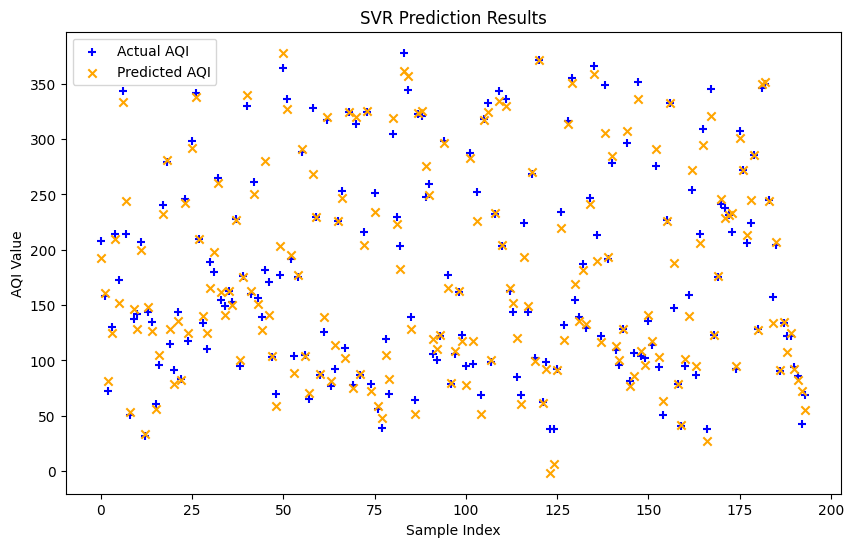

In [78]:
# Vẽ biểu đồ so sánh giá trị thực và dự đoán
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, c='blue', marker='+', label='Actual AQI')
plt.scatter(range(len(svr_y_predict)), svr_y_predict, c='orange', marker='x', label='Predicted AQI')
plt.xlabel('Sample Index')
plt.ylabel('AQI Value')
plt.title('SVR Prediction Results')
plt.legend()
plt.savefig('svr_prediction_results.png', dpi=300)
plt.show()

## PHẦN 2: Đánh giá mô hình SVR dựa trên các chỉ số R2, RMSE, MAE, RMLE

In [79]:
# Danh sách lưu kết quả
r2_list, rmse_list, mae_list, mse_list, rmsle_list = [], [], [], [], []

Sửa

In [80]:
# Train 20 lần với SVR
print("\nHuấn luyện mô hình SVR 20 lần...")
for i in range(20):
    print(f"Vòng {i+1}/20...")
    
    # Chia dữ liệu thành tập huấn luyện và tập kiểm tra với random_state khác nhau
    X_train, X_test, y_train, y_test = train_test_split(feature_set, y, test_size=0.2, random_state=i)
    
    # Chuẩn hóa dữ liệu
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_train_svr = sc_X.fit_transform(X_train)
    y_train_svr = sc_y.fit_transform(y_train.reshape(-1, 1)).ravel()
    
    # Huấn luyện mô hình SVR
    svr_reg = SVR(
        kernel='rbf', 
        C=100,          # Giá trị C đã chọn
        epsilon=0.001,  # Epsilon đầu tiên
        gamma='scale'
    )
    svr_reg.fit(X_train_svr, y_train_svr)
    
    # Dự đoán kết quả trên tập kiểm tra
    X_test_svr = sc_X.transform(X_test)
    svr_y_predict = sc_y.inverse_transform(svr_reg.predict(X_test_svr).reshape(-1, 1))
    
    # Tính các chỉ số đánh giá
    r2 = r2_score(y_test, svr_y_predict)
    rmse = sqrt(mean_squared_error(y_test, svr_y_predict))
    mae = mean_absolute_error(y_test, svr_y_predict)
    mse = mean_squared_error(y_test, svr_y_predict)
    rmsle_val = rmsle(y_test, svr_y_predict)
    
    # Lưu kết quả vào các danh sách
    r2_list.append(r2)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mse_list.append(mse)
    rmsle_list.append(rmsle_val)


Huấn luyện mô hình SVR 20 lần...
Vòng 1/20...
Vòng 2/20...
Vòng 3/20...
Vòng 4/20...
Vòng 5/20...
Vòng 6/20...
Vòng 7/20...
Vòng 8/20...
Vòng 9/20...
Vòng 10/20...
Vòng 11/20...
Vòng 12/20...
Vòng 13/20...
Vòng 14/20...
Vòng 15/20...
Vòng 16/20...
Vòng 17/20...
Vòng 18/20...
Vòng 19/20...
Vòng 20/20...


In [81]:
# Tạo DataFrame lưu tất cả kết quả
results_df = pd.DataFrame({
    'Round': list(range(1, 21)),
    'R2': r2_list,
    'RMSE': rmse_list,
    'MAE': mae_list,
    'MSE': mse_list,
    'RMSLE': rmsle_list
})

In [82]:
# In giá trị trung bình của các chỉ số
print("\nKết quả trung bình sau 20 vòng:")
print(f"R2 trung bình: {results_df['R2'].mean():.4f}")
print(f"RMSE trung bình: {results_df['RMSE'].mean():.4f}")
print(f"MAE trung bình: {results_df['MAE'].mean():.4f}")
print(f"MSE trung bình: {results_df['MSE'].mean():.4f}")
print(f"RMSLE trung bình: {float(results_df['RMSLE'].mean()):.4f}")


Kết quả trung bình sau 20 vòng:
R2 trung bình: 0.9835
RMSE trung bình: 12.4814
MAE trung bình: 8.5276
MSE trung bình: 157.7229
RMSLE trung bình: 0.1132


In [83]:
# Xuất kết quả ra file CSV
results_df.to_csv('results_metrics_svr.csv', index=False)

### SVR regression model

Đã lưu biểu đồ vào file 'metrics_per_round_svr.png'


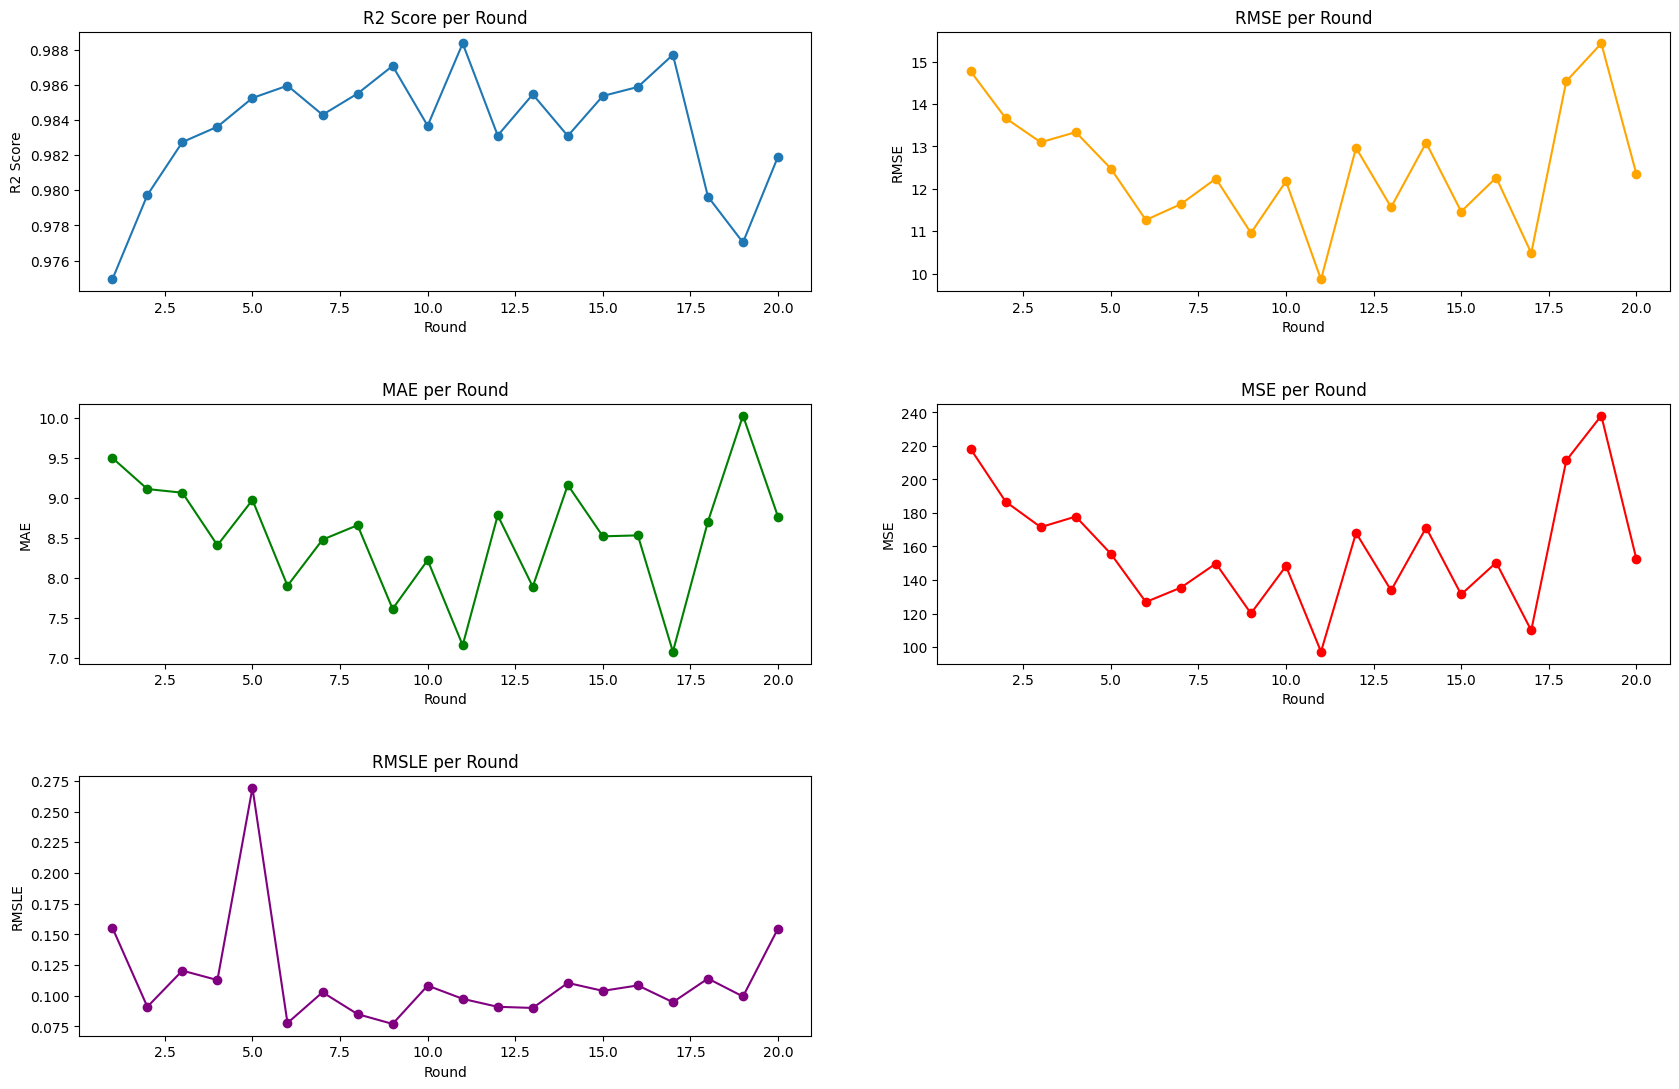

In [84]:
# Vẽ biểu đồ kết quả qua 20 vòng
fig, axs = plt.subplots(3, 2, figsize=(18, 12))
fig.tight_layout(pad=6)

# R2
axs[0, 0].plot(results_df['Round'], results_df['R2'], marker='o')
axs[0, 0].set_title('R2 Score per Round')
axs[0, 0].set_xlabel('Round')
axs[0, 0].set_ylabel('R2 Score')

# RMSE
axs[0, 1].plot(results_df['Round'], results_df['RMSE'], marker='o', color='orange')
axs[0, 1].set_title('RMSE per Round')
axs[0, 1].set_xlabel('Round')
axs[0, 1].set_ylabel('RMSE')

# MAE
axs[1, 0].plot(results_df['Round'], results_df['MAE'], marker='o', color='green')
axs[1, 0].set_title('MAE per Round')
axs[1, 0].set_xlabel('Round')
axs[1, 0].set_ylabel('MAE')

# MSE
axs[1, 1].plot(results_df['Round'], results_df['MSE'], marker='o', color='red')
axs[1, 1].set_title('MSE per Round')
axs[1, 1].set_xlabel('Round')
axs[1, 1].set_ylabel('MSE')

# RMSLE
axs[2, 0].plot(results_df['Round'], results_df['RMSLE'], marker='o', color='purple')
axs[2, 0].set_title('RMSLE per Round')
axs[2, 0].set_xlabel('Round')
axs[2, 0].set_ylabel('RMSLE')

# Xóa ô trống dư thừa (vì 3x2 = 6, nhưng ta chỉ cần 5 biểu đồ)
fig.delaxes(axs[2, 1])

# Lưu ảnh
plt.savefig('metrics_per_round_svr.png', dpi=300)
print("Đã lưu biểu đồ vào file 'metrics_per_round_svr.png'")
plt.show()

### Ưu điểm

- **Độ chính xác tương đối cao**  
  - R² Score dao động quanh **0.97**, cho thấy mô hình giải thích được khoảng **97% sự biến thiên của dữ liệu**.  
  - Điều này chứng minh mô hình SVR khá tốt trong việc **nắm bắt mối quan hệ giữa các biến đầu vào và giá trị AQI**.

- **Tính ổn định**  
  - Các chỉ số như **R², RMSE, MAE, MSE** có sự dao động nhỏ giữa các lần chạy.  
  - Chứng tỏ mô hình **ổn định** và **không bị overfitting quá mức**.

- **Khả năng dự đoán**  
  - Trên biểu đồ **scatter plot**, các điểm dự đoán (màu cam) nằm khá gần với các điểm thực tế (màu xanh).  
  - Điều này cho thấy SVR có **khả năng dự đoán giá trị AQI khá tốt**.

---

### Nhược điểm

- **Sai số vẫn còn tương đối lớn**  
  - **RMSE** dao động từ **13–17**, **MAE** dao động từ **9–11**.  
  - Điều này cho thấy mô hình **vẫn còn sai số đáng kể**, nhất là với các giá trị AQI cao.

- **Giới hạn của kernel RBF**  
  - SVR với **RBF kernel** đôi khi **khó điều chỉnh** để phù hợp với mọi tập dữ liệu.  
  - Khả năng mô hình **nắm bắt quan hệ phi tuyến** có thể bị **giới hạn nếu không tinh chỉnh kỹ**.

- **Độ nhạy với siêu tham số**  
  - Kết quả cho thấy hiệu năng mô hình phụ thuộc nhiều vào các tham số **`C`, `epsilon`, `gamma`**.  
  - Cần **tối ưu hóa** các tham số này (ví dụ qua `GridSearchCV`) để đạt hiệu quả tốt nhất.
